In [262]:
#!pip install deap 

In [263]:
import numpy as np
from deap import base, creator, tools
import random
import matplotlib.pyplot as plt
import time
from scipy.optimize import minimize
import json
import pandas as pd


## Setup

In [264]:
import numpy as np
import math
from deap import base, creator, tools
import random
import matplotlib.pyplot as plt
import time
from scipy.optimize import minimize
import json
import pandas as pd


class DataExploration:
    def __init__(self):
        self.fit_array = []

    def default_rastrigin(self, x, y):
        return 20 + x**2 + y**2 - 10 * (np.cos(2 * np.pi * x) + np.cos(2 * np.pi * y))

    def generateSimpleDataset(self):
        # Geração dos dados
        data = pd.DataFrame(
            {"x": np.linspace(-5, 5, 400), "y": np.linspace(-5, 5, 400)}
        )

        # display(data)

        # Generate meshgrid data
        x = np.linspace(-5.15, 5.15, 100)
        y = np.linspace(-5.15, 5.15, 100)
        X, Y = np.meshgrid(x, y)

        # Calculate function values
        # print(X.shape,Y.shape)

        return X, Y

    def plot_Rastrigin_2D(self, X, Y, Z_rastrigin, logbook, best_variables=[]):
        fig = plt.figure(figsize=(18, 10))
        ax1 = fig.add_subplot(231)
        generation = logbook.select("gen")
        statics = self.calculate_stats(logbook)
        line1 = ax1.plot(
            generation, statics["min_fitness"], "*b-", label="Minimum Fitness"
        )
        line2 = ax1.plot(
            generation, statics["avg_fitness"], "+r-", label="Average Fitness"
        )
        line3 = ax1.plot(
            generation, statics["max_fitness"], "og-", label="Maximum Fitness"
        )
        ax1.set_xlabel("Generation")
        ax1.set_ylabel("Fitness")
        ax1.set_title("GERAÇÃO X FITNESS")
        lns = line1 + line2 + line3
        labs = [l.get_label() for l in lns]
        ax1.legend(lns, labs, loc="upper right")

        # Rastrigin 2D
        ax2 = fig.add_subplot(232)
        ax2.contourf(X, Y, Z_rastrigin, levels=50, cmap="viridis")
        # ax2.plot(best_variables, color='red',)
        for num in range(len(best_variables)):
            var_x = round(best_variables[num])
            var_y = best_variables[num]
            ax2.scatter(var_x, var_y, color="pink", marker="o", label="best variables")
        ax2.set_title("Rastrigin Function 2D")
        ax2.set_xlabel("X")
        ax2.set_ylabel("Y")

        # Rastrigin 3D
        ax5 = fig.add_subplot(233, projection="3d")
        ax5.plot_surface(X, Y, Z_rastrigin, cmap="viridis", edgecolor="none")
        ax5.set_title("Rastrigin Function 3D")
        ax5.set_xlabel("X")
        ax5.set_ylabel("Y")
        ax5.set_zlabel("Z")

        plt.tight_layout()
        plt.show()

    def show_rastrigin_benchmark(self, logbook, best=[]):
        X, Y = self.generateSimpleDataset()

        Z_3D_rastrigin = self.default_rastrigin(X, Y)

        self.plot_Rastrigin_2D(X, Y, Z_3D_rastrigin, logbook, best)

    def statistics_per_generation_df(self, logbook):
        generations = logbook.select("gen")
        min_fitness = logbook.select("min")
        avg_fitness = logbook.select("avg")
        max_fitness = logbook.select("max")
        std_fitness = logbook.select("std")

        data = {
            "Generation": generations,
            "Min Fitness": min_fitness,
            "Average Fitness": avg_fitness,
            "Max Fitness": max_fitness,
            "Std Fitness": std_fitness,
        }

        df = pd.DataFrame(data)
        display(df)

    def plot_diversidade_genes(self, population):
        print("Plotando diversidade dos genes")
        fig = plt.figure()
        ax = fig.add_subplot(111, projection="3d")

        x_values = [ind[0] for ind in population]  # Retorna a primeira posição do vetor
        y_values = [ind[1] for ind in population]  # Retorna a segunda posição do vetor

        ax.scatter(x_values, y_values, c="b", label="Population")
        ax.set_title("Diversity of genes")
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.legend()
        plt.show()

    def plot_scatter_turbina(self, turbina, best_variables):
        # Plotar o gráfico de dispersão
        plt.figure(figsize=(10, 6))

        plt.scatter(
            turbina["Curva_Teórica(KWh)"],
            turbina["ActivePower(kW)"],
            label="Dados Reais",
            color="blue",
        )
        plt.plot(
            turbina["Curva_Teórica(KWh)"],
            best_variables * turbina["Curva_Teórica(KWh)"],
            label="Melhor Solução",
            color="red",
        )

        plt.xlabel("Potência Teórica (KWh)")
        plt.ylabel("Potência Ativa (kW)")
        plt.title("Comparação entre Potência Teórica e Potência Ativa")
        plt.legend()
        plt.grid(True)
        plt.show()

    def displayDataFrameInfo(self, array, text):
        # Criar DataFrame com as melhores soluções
        best_df = pd.DataFrame(array)
        self.cout(text)
        display(best_df)
        return best_df

    def show_conjuntoElite(self, pop):
        print("\n\n-->Conjunto Elite:", pop)
        best_df = pd.DataFrame(pop)
        display(best_df.sort_values(by="Fitness", ascending=False))

    def calculate_stats(self, logbook):

        fit_avg = logbook.select("avg")
        fit_std = logbook.select("std")
        fit_min = logbook.select("min")
        fit_max = logbook.select("max")

        self.fit_array.append(fit_min)
        self.fit_array.append(fit_avg)
        self.fit_array.append(fit_max)
        self.fit_array.append(fit_std)

        return {
            "min_fitness": fit_min,
            "max_fitness": fit_max,
            "avg_fitness": fit_avg,
            "std_fitness": fit_std,
        }

    def rastrigin(self, x):
        A = 10
        return A * len(x) + sum(
            [(x[i] ** 2 - A * np.cos(2 * math.pi * x[i])) for i in range(len(x))]
        )

    def cout(self, msg):
        print(
            "=========================================================================================="
        )
        print(msg)
        print(
            "=========================================================================================="
        )

    def visualize(self, logbook, pop, problem_type="minimaze", repopulation=True):
        generation = logbook.select("gen")
        statics = self.calculate_stats(logbook)

        if problem_type == "maximize":
            # Se o problema for de maximização, inverter os valores de fitness para exibir corretamente o gráfico
            statics = {
                key: [-value for value in values] for key, values in statics.items()
            }

        if repopulation:
            best_solution_index = statics["min_fitness"].index(
                min(statics["min_fitness"])
            )
            print(best_solution_index)
            best_solution_variables = pop[0]
            best_solution_fitness = statics["min_fitness"][best_solution_index]
        else:
            best_solution_index = statics["min_fitness"].index(
                min(statics["min_fitness"])
            )
            best_solution_variables = logbook.select("min")
            best_solution_fitness = min(statics["min_fitness"])

        # Soluções do problema
        self.cout("Soluções do problema")
        print("\nBest solution generation = ", best_solution_index)
        print("\nBest solution variables =\n", best_solution_variables)
        print("\nBest solution fitness = ", best_solution_fitness)

        try:

            # Encontrar o ótimo global da função Rastrigin usando os valores fornecidos.
            # opt = minimize(
            #     self.rastrigin, best_solution_variables, method="Nelder-Mead", tol=1e-6
            # )
            # print("\nÓtimo global da função Rastrigin = ", opt.fun)
            # print("\nSolução ótima global = ", opt.x)
            # # Comparar as soluções obt
            # print(
            #     "\nPorcentagem de proximidade da solução em relação ao ótimo global = ",
            #     (1 - (best_solution_fitness / opt.fun)) * 100,
            #     "%",
            # )
            # distancia_otimoglobal = abs
            # print(
            #     f"\nDistância da solução em relação ao ótimo global = {distancia_otimoglobal}",
            # )

            self.grafico_convergencia(generation, statics, repopulation)
            self.graficoBarrasFitnessGeneration(generation, statics, repopulation)
        except:
            print("Erro validation :(")

    def grafico_convergencia(self, gen, lista, repopulation=False):
        fig, ax1 = plt.subplots()
        if repopulation:
            ax1.set_title("Com Repopulação")
        else:
            ax1.set_title("Sem Repopulação")

        line1 = ax1.plot(gen, lista["min_fitness"], "*b-", label="Minimum Fitness")
        line2 = ax1.plot(gen, lista["avg_fitness"], "+r-", label="Average Fitness")
        line3 = ax1.plot(gen, lista["max_fitness"], "og-", label="Maximum Fitness")
        ax1.set_xlabel("Generation")
        ax1.set_ylabel("Fitness")
        lns = line1 + line2 + line3
        labs = [l.get_label() for l in lns]
        ax1.legend(lns, labs, loc="upper right")

    def plot_grafico_barras(self, x, y):
        fig, ax = plt.subplots()
        ax.bar(x, y, color="b")
        ax.set_xlabel("Generation")
        ax.set_ylabel("Fitness")
        ax.set_title("Fitness por Geração")
        plt.show()

    def graficoBarrasFitnessGeneration(self, generation, lista, repopulation=False):
        fig, ax = plt.subplots()
        if repopulation:
            ax.set_title("Com Repopulação")
        else:
            ax.set_title("Sem Repopulação")

        if len(generation) > 1:
            best_solutions = [min(lista["min_fitness"]) for i in range(len(generation))]
            avg_fitness = lista["avg_fitness"]
            generations = np.arange(1, len(generation) + 1)

            ax.plot(
                generations,
                avg_fitness,
                marker="o",
                color="r",
                linestyle="--",
                label="Média Fitness por Geração",
            )
            ax.bar(
                generations,
                lista["min_fitness"],
                color="green",
                label="Melhor Fitness por Geração",
            )

            ax.set_xlabel("Geração")
            ax.set_ylabel("Fitness")
            ax.set_title("Melhor Fitness e Média por Geração")
            ax.legend()
            plt.show()

    def plot_diversidade(self, population, repopulation=False):
        fig = plt.figure()
        ax = fig.add_subplot(111, projection="3d")

        if repopulation:
            ax.set_title("Com Repopulação")
        else:
            ax.set_title("Sem Repopulação")

        x_values = [ind[0] for ind in population]
        y_values = [ind[1] for ind in population]
        z_values = [ind[2] for ind in population]

        ax.scatter(x_values, y_values, z_values, c="b", label="Population")

        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.set_zlabel("Z")
        ax.legend()
        ax.grid(True)

        plt.show()

In [265]:
import numpy as np
import math
from deap import base, creator, tools
import random
import matplotlib.pyplot as plt
import time
from scipy.optimize import minimize
import json
import pandas as pd


class Setup:
    def __init__(self, params, dadosEntrada=None):

        #! Parametros JSON
        self.params = params
        self.DADOS_ENTRADA = dadosEntrada  # Dados da entrada do usuario

        self.CXPB = params["CROSSOVER"]
        self.MUTPB = params["MUTACAO"]
        self.NGEN = params["NUM_GENERATIONS"]
        self.POP_SIZE = params["POP_SIZE"]
        self.SIZE_INDIVIDUAL = params["IND_SIZE"]
        self.TAXA_GENERATION = params["RCE_REPOPULATION_GENERATIONS"]
        self.CROSSOVER, self.MUTACAO, self.NUM_GENERATIONS, self.POPULATION_SIZE = (
            self.CXPB,
            self.MUTPB,
            self.NGEN,
            self.POP_SIZE,
        )

        self.NUM_VAR_DIF = params["NUM_VAR_DIFERENTES"]
        self.porcentagem = params["PORCENTAGEM"]
        self.delta = params["VALOR_LIMITE"]

        #! Parâmetros do algoritmo de Rastrigin
        self.evaluations = 0
        self.num_repopulation = int(self.NUM_GENERATIONS * self.TAXA_GENERATION)
        self.type = params["type"].lower()
        if self.type == "maximize":
            print("Método escolhido: Maximizar")
            creator.create("Fitness", base.Fitness, weights=(1.0,))
        else:
            print("Método escolhido: Minimizar")
            creator.create("Fitness", base.Fitness, weights=(-1.0,))

        self.dataset = {}

        #!Criando individuo pelo deap com seus atributos
        self.toolbox = base.Toolbox()

        # Função de fitness de minimização
        creator.create("FitnessMin", base.Fitness, weights=(-1.0,))

        # parâmetros
        creator.create(
            "Individual", list, fitness=creator.FitnessMin, rce=str, index=int
        )

        # Variavel de decisão
        self.toolbox.register("attribute", random.uniform, -5.12, 5.12)

        # registrando os individuos
        self.toolbox.register(
            "individual",
            tools.initRepeat,
            creator.Individual,
            self.toolbox.attribute,
            n=self.SIZE_INDIVIDUAL,
        )

        #! individuos com dados de entrada
        if self.DADOS_ENTRADA:
            creator.create(
                "FrameworkIndividual",
                list,
                fitness=creator.FitnessMin,
                tipo=self.DADOS_ENTRADA[0],
                rce=str,
            )
            self.toolbox.register(
                "varDecision",
                random.uniform,
                self.DADOS_ENTRADA[2][0],
                self.DADOS_ENTRADA[2][1],
            )
            self.toolbox.register(
                "newIndividual",
                tools.initRepeat,
                creator.FrameworkIndividual,
                self.toolbox.varDecision,
                n=self.DADOS_ENTRADA[1],
            )

            self.toolbox.register(
                "FrameworkPopulation",
                tools.initRepeat,
                list,
                self.toolbox.newIndividual,
            )

        #! paramentos evolutivos
        self.toolbox.register(
            "population", tools.initRepeat, list, self.toolbox.individual
        )

        self.toolbox.register("mate", tools.cxTwoPoint)
        self.toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.1)
        self.toolbox.register("select", tools.selTournament, tournsize=3)
        self.toolbox.register("evaluate", self.evaluate_fitness)

    def evaluate_fitness(self, individual):
        if self.type == "minimaze":
            result = minimize(
                self.rastrigin, x0=np.zeros(self.SIZE_INDIVIDUAL), method="BFGS"
            )
            fitness_value = result.fun
        return fitness_value

    def gerarDataset(self, excel):
        df = pd.read_excel(excel)
        print(df.columns)
        self.dataset = {
            "CXPB": self.CROSSOVER,
            "TAXA_MUTACAO": self.MUTACAO,
            "NUM_GEN": self.NUM_GENERATIONS,
            "POP_SIZE": self.POPULATION_SIZE,
            "IND_SIZE": self.SIZE_INDIVIDUAL,
            "evaluations": self.evaluations,
            "NUM_REPOPULATION": self.num_repopulation,
        }

    def rastrigin(self, individual):
        self.evaluations += 1
        rastrigin = 10 * self.SIZE_INDIVIDUAL
        for i in range(self.SIZE_INDIVIDUAL):
            rastrigin += individual[i] * individual[i] - 10 * (
                math.cos(2 * np.pi * individual[i])
            )
        return rastrigin

    def rastrigin_decisionVariables(self, individual, decision_variables):
        self.evaluations += 1
        rastrigin = 10 * len(decision_variables)
        for i in range(len(decision_variables)):
            rastrigin += individual[i] * individual[i] - 10 * (
                math.cos(2 * np.pi * individual[i])
            )
        return rastrigin

    def rosenbrock(self, x):
        return np.sum(100 * (x[1:] - x[:-1] ** 2) ** 2 + (1 - x[:-1]) ** 2)

    def globalSolutions(self):
        n_dimensions = 2

        try:
            rastrigin_result = minimize(
                self.rastrigin, x0=np.zeros(n_dimensions), method="BFGS"
            )
            rastrigin_minimum = rastrigin_result.fun
            rastrigin_solution = rastrigin_result.x

            rosenbrock_result = minimize(
                self.rosenbrock, x0=np.zeros(n_dimensions), method="BFGS"
            )
            rosenbrock_minimum = rosenbrock_result.fun
            rosenbrock_solution = rosenbrock_result.x

        except Exception as e:
            print("Erro ao tentar encontrar o ótimo global das funções: ", e)

        print("\n\nÓtimo global da função Rastrigin: ", rastrigin_minimum)
        print("Solução: ", rastrigin_solution)
        print()
        print("Ótimo global da função Rosenbrock: ", rosenbrock_minimum)
        print("Solução: ", rosenbrock_solution)

In [266]:
def load_params(file_path):
    with open(file_path, "r") as file:
        params = json.load(file)
    return params


params = load_params(
    r"/home/pedrov/Documentos/GitHub/Engenharia-Eletrica-UFF/Iniciação Cientifica - Eng Eletrica UFF/evolution_rce_master/src/db/parameters.json"
)
import easygui

class GUI_RCE:
    def __init__(self) -> None:
        self.window_title = "Calculadora de IMC"

        self.setup = Setup(params=params)

    def MaterialAPP(self):
        msg = "Insira seus dados abaixo:"
        title = self.window_title
        fieldNames = [
            "CROSS",
            "MUTAÇÃO",
            "GERAÇÕES",
            "POPULAÇÃO",
            "TAXA RCE",
            "DELTA",
            "PORCENTAGEM C1",
        ]
        fieldNames_defs = [
            self.setup.CXPB,
            self.setup.MUTPB,
            self.setup.NGEN,
            self.setup.POP_SIZE,
            self.setup.TAXA_GENERATION,
            self.setup.NUM_VAR_DIFF,
            self.setup.porcentagem,
        ]
        fieldValues = easygui.multenterbox(msg, title, fieldNames, fieldNames_defs)

        while 1:
            if fieldValues == None:
                break
            errmsg = ""
            for i in range(len(fieldNames)):
                if fieldValues[i].strip() == "":
                    errmsg = errmsg + ('"%s" is a required field.\n\n' % fieldNames[i])
            if errmsg == "":
                break  # no problems found
            fieldValues = easygui.multenterbox(errmsg, title, fieldNames, fieldValues)
        return fieldValues

    def display_result(
        self,
    ):
        message = "Voce com {age} anos, {name}, tem seu IMC é: {imc:.2f}"

        print(message)




## Algoritimo Evolutivo

In [267]:
import numpy as np
import math
from deap import base, creator, tools
import random
import matplotlib.pyplot as plt
import time
from scipy.optimize import minimize
import json
import pandas as pd
import numpy as np
import math
from deap import base, creator, tools
import random
import matplotlib.pyplot as plt
import time
from scipy.optimize import minimize
import json
import pandas as pd


class AlgoritimoEvolutivoRCE:
    def __init__(self, setup):
        self.setup = setup
        self.stats = tools.Statistics(key=lambda ind: ind.fitness.values)
        self.stats.register("avg", np.mean)
        self.stats.register("std", np.std)
        self.stats.register("min", np.min)
        self.stats.register("max", np.max)

        self.logbook = tools.Logbook()
        self.hof = tools.HallOfFame(1)
        self.POPULATION = self.setup.toolbox.population(n=self.setup.POP_SIZE)
        self.hof.update(self.POPULATION)

        if self.setup.DADOS_ENTRADA:
            self.POP_OPTIMIZATION = self.setup.toolbox.population(n=self.setup.POP_SIZE)

        self.pop_RCE = []
        self.best_solutions_array = []
        self.best_individual_array = []
        self.allIndividualValuesArray = []
        self.data = {}
        self.repopulation_counter = 0
        self.allFitnessValues = {}
        self.validateCounter = 0
        self.CONJUNTO_ELITE_RCE = set()

    def registrarDados(self, generation):

        # Registrar estatísticas e melhores soluções
        for ind in self.POPULATION:
            avg_fitness_per_generation = np.mean(ind.fitness.values)
            std_deviation = np.std(ind.fitness.values)

        #! PEgandos os dados e colocando no df
        self.data = {
            "Generations": generation + 2,
            "Variaveis de Decisão": self.hof[0],
            "Evaluations": self.setup.evaluations,
            "Ind Valido": self.hof[0].fitness.valid,
            "Best Fitness": self.hof[0].fitness.values,
            "Media": avg_fitness_per_generation,
            "Desvio Padrao": std_deviation,
        }

        self.best_individual_array.append(self.data)

        self.visualizarPopAtual(generation, [avg_fitness_per_generation, std_deviation])

    def checkClonesInPop(self, ind, new_pop):
        is_clone = False
        for other_ind in new_pop:
            if (
                ind == other_ind
                and sum(ind) == sum(other_ind)
                and ind.index != other_ind.index
            ):
                is_clone = True
                break
        return is_clone

    def generateInfoIndividual(self, new_pop, generation):
        ind_array = []

        for i, ind in enumerate(new_pop):
            # print(f"Index[{ind.index}] - ind_variables {ind} \n Fitness = {ind.fitness.values} ")

            ind.index = i

            ind_info = {
                "Generations": generation,
                "index": ind.index,
                "Variaveis de Decisão": ind,
                "Fitness": ind.fitness.values[0],
                "RCE": ind.rce,
                "Diversidade": np.sum(ind),
            }

            # Adicionar a informação de clone ao dicionário
            # is_clone = self.checkClonesInPop(ind, new_pop)
            # ind_info["CLONE"] = "SIM" if is_clone else "NAO"

            ind_array.append(ind_info)

        return ind_array

    def show_ind_df(self, array, text):
        df = pd.DataFrame(array)
        print(text)
        display(df.head(50))

        # contar quantos SIM na coluna CLONE se a coluna RCE for SIM
        # display(df[df["RCE"] != ""].value_counts())

    def criterio1(self, new_pop, porcentagem, k=30):
        """Seleciona os candidatos ao conjunto elite com base nas diferenças percentuais de aptidão."""
        self.cout(f"CRITÉRIO 1 RCE - Selecionando candidatos ao conjunto elite")
        elite_individuals = []

        # Ordenar a população em ordem crescente de aptidão e selecionar os k primeiros indivíduos
        sorted_population = sorted(self.POPULATION, key=lambda x: x.fitness.values[0])

        # Obter o melhor indivíduo (HOF) da população
        best_ind = new_pop[0]
        best_fitness = best_ind.fitness.values[0]
        max_difference = (1 + porcentagem) * best_fitness

        # Selecionar com as menores diferenças percentuais
        for ind in sorted_population:
            if ind.fitness.values[0] <= max_difference:
                elite_individuals.append(ind)
            else:
                break  # Parar a seleção quando a diferença percentual for maior que o limite

        # Colocando na pop aleatória
        print(
            f"Calculando percentual de {porcentagem*100}% com base no melhor fitness = {best_fitness} e pegando os {len(elite_individuals)} melhores.\n Porcentagem de {best_fitness} = {max_difference} "
        )
        for i, ind in enumerate(elite_individuals):
            new_pop[i] = self.setup.toolbox.clone(ind)
            new_pop[i].rce = "SIM_1"

        return elite_individuals

    def criterio2_alternative(self, ind_selecionados, delta=6):
        """Comparar as variáveis de decisão de cada indivíduo e verificar se existem diferenças superiores a 'delta'."""
        self.cout(
            f"CRITÉRIO 2 - Comparar as variáveis de decisão de cada indivíduo e verificar valores superiores a 'delta' = {delta}."
        )
        self.CONJUNTO_ELITE_RCE.clear()

        for i in range(len(ind_selecionados)):

            #    todo   Calcular Diff - diferença entre as variáveis de indivíduo e individuo lista

            diff = np.array(ind_selecionados[i]) - np.array(ind_selecionados[0])

            # todo retornar true ou false caso ind seja diferente para colocar no array correto
            if sum(diff) > delta:  # ind diferente
                if (ind_selecionados[i] not in self.pop_RCE) and (
                    ind_selecionados[i] not in ind_selecionados[0]
                ):
                    self.pop_RCE.append(self.POP_OPTIMIZATION[i])
                    self.CONJUNTO_ELITE_RCE.add(tuple(self.POP_OPTIMIZATION[i]))
                    ##print("Delta= ", sum(diff))

        if not self.pop_RCE:
            print("Nenhum indivíduo atende aos critérios. :( ")

        print("Tamanho Elite = ", len(self.pop_RCE))
        print("Tamanho Elite = ", len(self.CONJUNTO_ELITE_RCE))

        return self.pop_RCE

    def newCriterio(self, population):
        self.CONJUNTO_ELITE_RCE.clear()
        self.pop_RCE = []

        def criterio1_reduzido(population):
            #! critério 1 e obtém os N melhores com 30% do valor do melhor fitness

            best_ind = self.elitismoSimples(population)[0]
            best_fitness = best_ind.fitness.values[0]
            max_difference = (1 + self.setup.porcentagem) * best_fitness
            print(
                f"Fitness ({self.setup.porcentagem * 100})% = {round(max_difference,3)}"
            )
            return max_difference, best_ind

        self.cout("Criterio 1 - Pegando o valor máximo de Fitness para selecionar individuos")
        max_difference, best_ind = criterio1_reduzido(population)
        self.pop_RCE.append(best_ind)

        def calculaDiff(ind, lista):
            count = 0

            # calcula a diferença entre o ind selecionado e o pessoal do RCE
            for i in range(0,len(lista)):
                diff = abs(np.array(ind) - np.array(lista[i]))
                array = list(diff)

                # pegando quantos valores nao sao nulos  -> caso tenha valor limite
                if (sum(array)> 0.0):
                    for value in array:
                        if value > self.setup.NUM_VAR_DIF:
                            count += 1

                    # se o contador for maior que delta
                    if count >= self.setup.delta:
                        # print("\nArray diferente")

                        # print(" diff", array)

                        print("Var decision diferentes = ", count)
                        return True

                    else:
                        return False # sem diversidade suficiente
                else:
                    return False # clone: Variaveis iguais

        self.cout(f"New - CRITÉRIO 2 RCE ")
        for ind in population:
            # criterio 1
            if ind.fitness.values[0] <= max_difference:
                # criterio 2
                diferente = calculaDiff(ind, self.pop_RCE) # delta como valor limite
                if diferente:
                    if ind not in self.pop_RCE:
                        self.pop_RCE.append(ind)
                        self.CONJUNTO_ELITE_RCE.add(tuple(ind))

        if len(self.pop_RCE) == 1:
            print("Nenhum indivíduo atende aos critérios. :( ")

        print("\nTamanho Elite = ", len(self.pop_RCE))
        print("Tamanho Elite = ", len(self.CONJUNTO_ELITE_RCE))

        return self.pop_RCE

    def aplicar_RCE(self, generation, current_population):

        #! a - Cria uma pop aleatória (eliminando a pop aleatória criada na execução anterior do RCE)
        new_pop = self.setup.toolbox.population(
            n=self.setup.POP_SIZE
        )  # retorna uma pop com lista de individuos de var de decisão

        # Avaliar o fitness da população atual
        self.avaliarFitnessIndividuos(current_population)
        self.calculateFitnessGeneration(current_population)

        #! b - Coloca o elite hof da pop anterior  no topo (0)
        pop = self.elitismoSimples(current_population)
        print(
            f"Elitismo HOF Index[{pop[0].index}] {pop[0]} \n Fitness = {pop[0].fitness.values} | Diversidade = {sum(pop[0])}"
        )  # pop[0] é o melhor individuo HOF
        new_pop[0] = self.setup.toolbox.clone(pop[0])

        #! Critério 2 usando este array e vai colocando os indivíduos selecionados pelo critério 2 na pop aleatória (passo a)
        ind_diferentes_var = self.newCriterio(
            current_population, 
        )

        # cOLOCANDO ATRIBUTOS
        for i, ind in enumerate(ind_diferentes_var, start=0):
            new_pop[0].rce = "HOF"
            if i > 0:
                new_pop[i] = self.setup.toolbox.clone(ind)
                new_pop[i].rce = "SIM"

        #! Criterio 3 retorna pop aleatória modificada (com hof + rce + Aleatorio)
        self.calculateFitnessGeneration(new_pop)
        self.cout(f"CRITERIO 3 - População aleatória modificada [HOF,RCE,Aleatorio] ")
        conjunto_elite = self.generateInfoIndividual(new_pop, generation)
        self.show_ind_df(conjunto_elite, "Individuos da nova população aleatória")
        return new_pop

    def elitismoSimples(self, pop):
        self.hof.update(pop)
        pop[0] = self.setup.toolbox.clone(self.hof[0])
        return pop

    def criterio2(self, elite_individuals, delta):
        """Comparar as variáveis de decisão de cada indivíduo e verificar se existem diferenças superiores a 'delta'."""
        self.cout(
            f"CRITÉRIO 2 - Comparar as variáveis de decisão de cada indivíduo e verificar se existem diferenças superiores a 'delta' = {delta}."
        )
        self.pop_RCE = []
        self.CONJUNTO_ELITE_RCE.clear()

        for i in range(len(elite_individuals)):
            current_individual = elite_individuals[i]
            is_diferente = False

            for j in range(i + 1, len(elite_individuals)):
                other_individual = elite_individuals[j]
                diff_counter = 0

                for var_index in range(len(current_individual)):
                    current_var = current_individual[var_index]
                    other_var = other_individual[var_index]

                    if abs(current_var - other_var) > delta:
                        # print(abs(current_var - other_var))
                        diff_counter += 1

                if diff_counter >= 1:
                    is_diferente = True

            if is_diferente:
                # print(f"Indivíduo do tipo {type(current_individual)} VAR({current_individual})\n diferente! adicionado à nova população.")
                self.pop_RCE.append(current_individual)
                self.CONJUNTO_ELITE_RCE.add(tuple(current_individual))

        if not self.pop_RCE:
            print("Nenhum indivíduo atende aos critérios. :( ")

        print("Tamanho Elite = ", len(self.pop_RCE))
        return self.pop_RCE

    def avaliarFitnessIndividuos(self, pop):
        """Avaliar o fitness dos indivíduos da população atual."""
        fitnesses = map(self.setup.toolbox.evaluate, pop)
        for ind, fit in zip(pop, fitnesses):
            if ind.fitness.values:
                ind.fitness.values = [fit]

    def calculateFitnessGeneration(self, new_pop):
        # Calculando o fitness para geração
        for ind in new_pop:
            if not ind.fitness.valid:
                fitness_value = self.setup.toolbox.evaluate(ind)
                ind.fitness.values = (fitness_value,)

    def checkDecisionVariablesAndFitnessFunction(
        self, decision_variables, fitness_function
    ):

        # Verificar se as variáveis de decisão e a função de fitness foram fornecidas
        if decision_variables is None and fitness_function is None:
            # Gerar variáveis de decisão aleatórias para os indivíduos
            decision_variables = [
                random.random() for _ in range(self.setup.SIZE_INDIVIDUAL)
            ]

            # Definir a função de fitness padrão como a função Rastrigin
            fitness_function = self.setup.rastrigin_decisionVariables

        if decision_variables is None or fitness_function is None:
            if not hasattr(self, "decision_variables") or not hasattr(
                self, "fitness_function"
            ):
                raise ValueError(
                    "Variáveis de decisão e função de fitness não definidas. Use set_decision_variables_and_fitness_function primeiro."
                )
        else:
            self.decision_variables = decision_variables
            self.fitness_function = fitness_function

            # Definir a função de fitness com base na função fornecida
            def fitness_func(individual):
                return self.fitness_function(individual, self.decision_variables)

            # Registrar a função de fitness no toolbox
            self.setup.toolbox.register("evaluate", fitness_func)

    #! Main LOOP
    def run(self, RCE=False, decision_variables=None, fitness_function=None, num_pop=0):

        if self.setup.DADOS_ENTRADA:
            population = [self.POPULATION, self.POP_OPTIMIZATION]
        else:
            population = [self.POPULATION]

        # Avaliar o fitness da população inicial
        self.avaliarFitnessIndividuos(population[num_pop])

        # Selecionando as variaveis de decisao e afuncao objeti
        self.checkDecisionVariablesAndFitnessFunction(
            decision_variables, fitness_function
        )

        #! Loop principal através das gerações
        for current_generation in range(self.setup.NGEN):

            # Selecionar os indivíduos para reprodução
            offspring = self.setup.toolbox.select(
                population[num_pop], k=len(population[num_pop])
            )

            # Clone the selected individuals
            offspring = [self.setup.toolbox.clone(ind) for ind in offspring]

            # Aplicar crossover
            for child1, child2 in zip(offspring[::2], offspring[1::2]):
                if random.random() < self.setup.CXPB:
                    self.setup.toolbox.mate(child1, child2)
                    del child1.fitness.values
                    del child2.fitness.values

            # Aplicar mutação
            for mutant in offspring:
                if random.random() < self.setup.MUTPB:
                    self.setup.toolbox.mutate(mutant)
                    del mutant.fitness.values

            #  Avaliar o fitness dos novos indivíduos
            invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
            fitnesses = map(self.setup.toolbox.evaluate, invalid_ind)
            for ind, fit in zip(invalid_ind, fitnesses):
                ind.fitness.values = [fit]

            #! Aplicar RCE
            if RCE and ((current_generation + 1) % self.setup.num_repopulation == 0):
                print("")
                self.cout(
                    f"RCE being applied! - Generation = {current_generation + 1} ",
                )
                #! f - copia pop aleatória modificada retornada para pop atual
                new_population = self.aplicar_RCE(
                    current_generation + 1, population[num_pop]
                )
                # print("\nPopulação gerada pelo RCE\n", population[num_pop])
                population[num_pop][:] = new_population
            else:
                population[num_pop][:] = offspring

            # Registrar estatísticas no logbook
            self.elitismoSimples(population[num_pop])
            self.registrarDados(current_generation)
            record = self.stats.compile(population[num_pop])
            self.logbook.record(gen=current_generation, **record)

        # Retornar população final, logbook e elite
        return population[num_pop], self.logbook, self.hof[0]

    def visualizarPopAtual(self, geracaoAtual, stats):

        for i in range(len(self.POPULATION)):
            datasetIndividuals = {
                "Generations": geracaoAtual + 1,
                "index": i,
                "Variaveis de Decisão": self.POPULATION[i],
                "Fitness": self.POPULATION[i].fitness.values,
                "Media": stats[0],
                "Desvio Padrao": stats[1],
                "RCE": " - ",
            }
            self.allIndividualValuesArray.append(datasetIndividuals)

    def cout(self, msg):
        print(
            "\n=========================================================================================================="
        )
        print("\t", msg)
        print(
            "==========================================================================================================\n"
        )


def load_params(file_path):
    with open(file_path, "r") as file:
        params = json.load(file)
    return params

## Exemplo

In [268]:
# Exemplo dados tubina eolica
#! Carregar os dados
turbina = pd.read_csv(
    r"/home/pedrov/Documentos/GitHub/Engenharia-Eletrica-UFF/Iniciação Cientifica - Eng Eletrica UFF/evolution_rce_master/src/assets/datasets/T1.csv"
)
turbina.columns = [
    "Data/hora",
    "ActivePower(kW)",
    "WindSpeed(m/s)",
    "Curva_Teórica(KWh)",
    "Direção do Vento",
]
display(turbina.head())

X = turbina[['WindSpeed(m/s)']].values
y = turbina[['ActivePower(kW)']].values
data_hora = turbina[['Data/hora']].values
curva = turbina[['Curva_Teórica(KWh)']].values
vento = turbina[['Direção do Vento']].values

print(X.shape,y.shape)


def rastrigin_decisionVariables( individual, decision_variables):
    rastrigin = 10 * len(decision_variables)
    for i in range(len(decision_variables)):
        rastrigin += individual[i] * individual[i] - 10 * (
                math.cos(2 * np.pi * individual[i])
            )
    return rastrigin



,Data/hora,ActivePower(kW),WindSpeed(m/s),Curva_Teórica(KWh),Direção do Vento
0,01 01 2018 00:00,380.047791,5.311336,416.328908,259.994904
1,01 01 2018 00:10,453.769196,5.672167,519.917511,268.641113
2,01 01 2018 00:20,306.376587,5.216037,390.900016,272.564789
3,01 01 2018 00:30,419.645905,5.659674,516.127569,271.258087
4,01 01 2018 00:40,380.650696,5.577941,491.702972,265.674286


(50530, 1) (50530, 1)


In [269]:
## problema da mochila - combinatria do tipo binario

# SA -> https://github.com/brunodeathayde/SA_TSP/blob/main/main_SA.py

#evolution
prob_dict = {
    "tipo": "binario",
    "num_var": 8,
    "lim_var": [1,12],
    "fitness": 0,
}

#problema
multa = 1000
pop = 10
capacidade_mochila = 15
quantidade_itens = [1,8,3,12,7,5,6,3]
lucro = [2,5,3,10,8,1,3,4]
fitness = lambda x: (capacidade_mochila - sum(quantidade_itens[x])) * multa * sum(lucro)

#print(fitness(2))

## Main

https://deap.readthedocs.io/en/master/api/tools.html

Método escolhido: Minimizar
Método escolhido: Minimizar


/home/pedrov/.local/lib/python3.11/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pedrov/.local/lib/python3.11/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pedrov/.local/lib/python3.11/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "




	 RCE being applied! - Generation = 40 

Elitismo HOF Index[0] [-0.004187308429572489, -0.9945258252836892, 4.914300383555734, 3.0676320417504774, 3.3946926436955955, -5.081304699116296, 3.5871645312614406, 4.753920000409313, -5.060622826566008, 4.056285749044775] 
 Fitness = (0.998474519897913,) | Diversidade = 12.63335469032177

	 Criterio 1 - Pegando o valor máximo de Fitness para selecionar individuos

Fitness (30.0)% = 1.298

	 New - CRITÉRIO 2 RCE 

Nenhum indivíduo atende aos critérios. :( 

Tamanho Elite =  1
Tamanho Elite =  0

	 CRITERIO 3 - População aleatória modificada [HOF,RCE,Aleatorio] 

Individuos da nova população aleatória


,Generations,index,Variaveis de Decisão,Fitness,RCE,Diversidade
0,40,0,"[-0.004187308429572489, -0.9945258252836892, 4...",0.998475,HOF,12.633355
1,40,1,"[-5.066509195606624, 5.114129865272083, 1.2102...",55.147212,,-8.252703
2,40,2,"[-4.569633628128667, -3.0049873902853506, 4.04...",48.974458,,-9.504360
3,40,3,"[-1.501165440070372, -3.2647719621875604, 1.47...",43.838783,,0.789563
4,40,4,"[-3.7828999371952827, 4.186347019494156, 1.448...",45.889697,,-2.326116
5,40,5,"[2.7908664559558245, 4.2897286186558565, 2.345...",46.121494,,10.587793
6,40,6,"[3.889653143343586, -3.0472017159805227, 1.873...",27.160193,,-10.347271
7,40,7,"[3.37492410770719, 2.44043564032505, -4.036552...",53.721340,,8.620163
8,40,8,"[-3.381669068686472, -1.0902207680967138, -3.3...",31.549502,,-4.005861
9,40,9,"[-0.7838155155427522, 1.6931722597694803, 4.16...",24.867662,,4.291855




	 RCE being applied! - Generation = 80 

Elitismo HOF Index[0] [-0.004187308429572489, -0.03112582873636996, 0.45883282235806355, -2.2288380772544714, 3.3946926436955955, -4.656227279720046, -2.066062106277367, 3.8666241147225096, -3.0471556433132982, -2.3390492647336965] 
 Fitness = (0.1950752394305173,) | Diversidade = -6.652495927688652

	 Criterio 1 - Pegando o valor máximo de Fitness para selecionar individuos

Fitness (30.0)% = 0.254

	 New - CRITÉRIO 2 RCE 

Var decision diferentes =  3

Tamanho Elite =  2
Tamanho Elite =  1

	 CRITERIO 3 - População aleatória modificada [HOF,RCE,Aleatorio] 

Individuos da nova população aleatória


,Generations,index,Variaveis de Decisão,Fitness,RCE,Diversidade
0,80,0,"[-0.004187308429572489, -0.03112582873636996, ...",0.195075,HOF,-6.652496
1,80,1,"[-0.004187308429572489, -0.03112582873636996, ...",0.195075,SIM,3.417587
2,80,2,"[-3.5571880742807336, 4.2081739158464595, 0.28...",57.125800,,7.934776
3,80,3,"[0.36269680362431345, 2.0431128962895526, -4.0...",21.174397,,-5.213763
4,80,4,"[0.827800610647345, 4.472717584159198, -2.0042...",45.847909,,6.489981
5,80,5,"[-4.9345856643044295, 3.874651663133176, 1.865...",43.140310,,3.839279
6,80,6,"[0.7831379828384559, 1.557621508568805, 3.1432...",30.324119,,8.849746
7,80,7,"[2.392259345236777, 4.226459919497176, -1.6914...",49.907029,,-6.251978
8,80,8,"[-3.8640651360997675, 4.544342400647241, 4.256...",58.627486,,19.239608
9,80,9,"[1.9338335326665836, -1.2926873189114283, -1.7...",18.912641,,-12.196811




	 RCE being applied! - Generation = 120 

Elitismo HOF Index[1] [-0.004187308429572489, 0.012840760093258297, 0.19475283886588635, 3.0676320417504774, -1.1989052782361718, 3.535568785471276, -0.7800232000621827, 3.8666241147225096, -2.8937003203251095, -2.3390492647336965] 
 Fitness = (0.03617257021918796,) | Diversidade = 3.4615531691166757

	 Criterio 1 - Pegando o valor máximo de Fitness para selecionar individuos

Fitness (30.0)% = 0.047

	 New - CRITÉRIO 2 RCE 

Var decision diferentes =  2
Var decision diferentes =  2
Var decision diferentes =  2
Var decision diferentes =  2
Var decision diferentes =  2

Tamanho Elite =  6
Tamanho Elite =  5

	 CRITERIO 3 - População aleatória modificada [HOF,RCE,Aleatorio] 

Individuos da nova população aleatória


,Generations,index,Variaveis de Decisão,Fitness,RCE,Diversidade
0,120,0,"[-0.004187308429572489, 0.012840760093258297, ...",0.036173,HOF,3.461553
1,120,1,"[-0.004187308429572489, 0.012840760093258297, ...",0.036173,SIM,-7.158337
2,120,2,"[-0.004187308429572489, 0.012840760093258297, ...",0.036173,SIM,-1.980401
3,120,3,"[-0.004187308429572489, 0.012840760093258297, ...",0.036173,SIM,-3.550848
4,120,4,"[-0.004187308429572489, 0.012840760093258297, ...",0.036173,SIM,1.730060
5,120,5,"[-0.004187308429572489, 0.012840760093258297, ...",0.036173,SIM,-1.627876
6,120,6,"[-0.24557908169528186, -1.1301969199410316, 3....",14.223469,,11.041404
7,120,7,"[-4.956227634533908, -1.769625776318137, 4.060...",36.841596,,-3.984302
8,120,8,"[0.8762361181741776, 3.29913487236593, -3.5312...",27.564735,,9.143834
9,120,9,"[-3.916949658358349, 0.22128431433378104, 4.18...",24.927844,,-3.806605




	 RCE being applied! - Generation = 160 

Elitismo HOF Index[1] [-0.004187308429572489, 0.012840760093258297, 0.19475283886588635, 3.0676320417504774, -1.1989052782361718, 3.535568785471276, -0.7800232000621827, 3.8666241147225096, -2.8937003203251095, -2.3390492647336965] 
 Fitness = (0.03617257021918796,) | Diversidade = 3.4615531691166757

	 Criterio 1 - Pegando o valor máximo de Fitness para selecionar individuos

Fitness (30.0)% = 0.047

	 New - CRITÉRIO 2 RCE 

Var decision diferentes =  2
Var decision diferentes =  2
Var decision diferentes =  2
Var decision diferentes =  2
Var decision diferentes =  3
Var decision diferentes =  3
Var decision diferentes =  2
Var decision diferentes =  2
Var decision diferentes =  2
Var decision diferentes =  2
Var decision diferentes =  2
Var decision diferentes =  2
Var decision diferentes =  2
Var decision diferentes =  3
Var decision diferentes =  2
Var decision diferentes =  2
Var decision diferentes =  2
Var decision diferentes =  2
Var 

,Generations,index,Variaveis de Decisão,Fitness,RCE,Diversidade
0,160,0,"[-0.004187308429572489, 0.012840760093258297, ...",0.036173,HOF,3.461553
1,160,1,"[-0.004187308429572489, 0.012840760093258297, ...",0.036173,SIM,0.410305
2,160,2,"[-0.004187308429572489, 0.012840760093258297, ...",0.036173,SIM,0.147459
3,160,3,"[-0.004187308429572489, 0.012840760093258297, ...",0.036173,SIM,-6.481322
4,160,4,"[-0.004187308429572489, 0.012840760093258297, ...",0.036173,SIM,5.413994
5,160,5,"[-0.004187308429572489, 0.012840760093258297, ...",0.036173,SIM,-8.334424
6,160,6,"[-0.004187308429572489, 0.012840760093258297, ...",0.036173,SIM,-2.393769
7,160,7,"[-0.004187308429572489, 0.012840760093258297, ...",0.036173,SIM,-9.449901
8,160,8,"[-0.004187308429572489, 0.012840760093258297, ...",0.036173,SIM,0.092704
9,160,9,"[-0.004187308429572489, 0.012840760093258297, ...",0.036173,SIM,0.981761




	 RCE being applied! - Generation = 200 

Elitismo HOF Index[13] [-0.0009785885009750929, 0.012840760093258297, -4.785155052666272, 3.8845115419556047, -0.9006460574322164, -2.2260300518267173, 2.580738808856271, -2.205436695518073, 2.268034514893931, -4.2490582390090825] 
 Fitness = (0.03288423858781364,) | Diversidade = -5.6211790591542705

	 Criterio 1 - Pegando o valor máximo de Fitness para selecionar individuos

Fitness (30.0)% = 0.043

	 New - CRITÉRIO 2 RCE 

Var decision diferentes =  2
Var decision diferentes =  2
Var decision diferentes =  2
Var decision diferentes =  2
Var decision diferentes =  2
Var decision diferentes =  2
Var decision diferentes =  2

Tamanho Elite =  7
Tamanho Elite =  6

	 CRITERIO 3 - População aleatória modificada [HOF,RCE,Aleatorio] 

Individuos da nova população aleatória


,Generations,index,Variaveis de Decisão,Fitness,RCE,Diversidade
0,200,0,"[-0.0009785885009750929, 0.012840760093258297,...",0.032884,HOF,-5.621179
1,200,1,"[-0.0009785885009750929, 0.012840760093258297,...",0.032884,SIM,-6.500473
2,200,2,"[-0.0009785885009750929, 0.012840760093258297,...",0.032884,SIM,-8.974316
3,200,3,"[-0.0009785885009750929, 0.012840760093258297,...",0.032884,SIM,-10.029802
4,200,4,"[-0.0009785885009750929, 0.012840760093258297,...",0.032884,SIM,-12.397279
5,200,5,"[-0.0009785885009750929, 0.012840760093258297,...",0.032884,SIM,-7.019093
6,200,6,"[-0.0009785885009750929, 0.012840760093258297,...",0.032884,SIM,-9.959889
7,200,7,"[-0.06723198534717767, 2.502293472071937, 2.94...",27.144005,,-3.310174
8,200,8,"[-4.917275461026094, -0.4622695214017911, 0.01...",45.434283,,3.344633
9,200,9,"[4.083526875431255, -1.39878613540002, -0.3980...",38.022732,,-4.272043




Evolução concluída  - 100%

	 VISUALIZANDO OS RESULTADOS



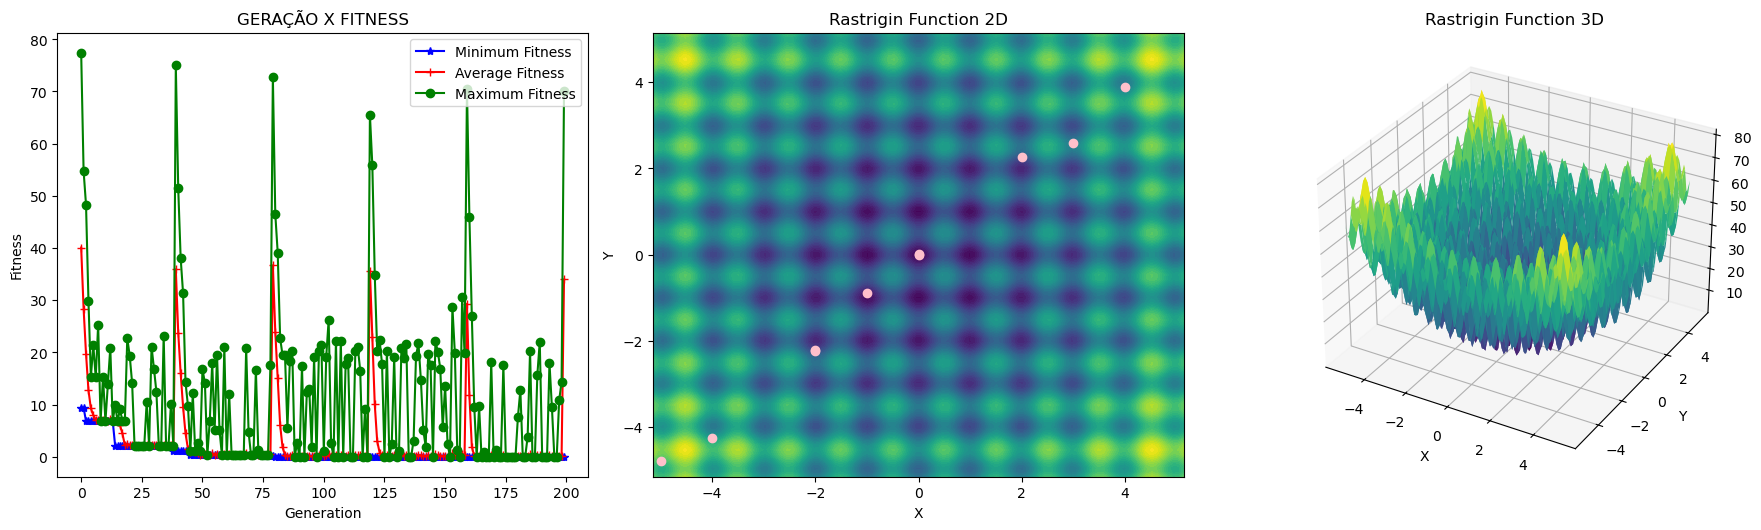

168
Soluções do problema

Best solution generation =  168

Best solution variables =
 [-0.0009785885009750929, 0.012840760093258297, -4.785155052666272, 3.8845115419556047, -0.9006460574322164, -2.2260300518267173, 2.580738808856271, -2.205436695518073, 2.268034514893931, -4.2490582390090825]

Best solution fitness =  0.03288423858781364


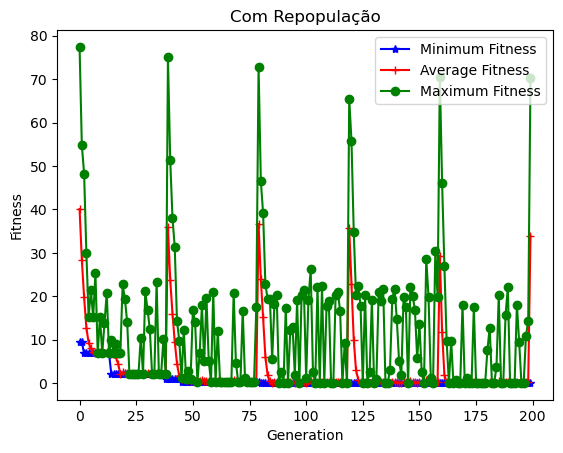

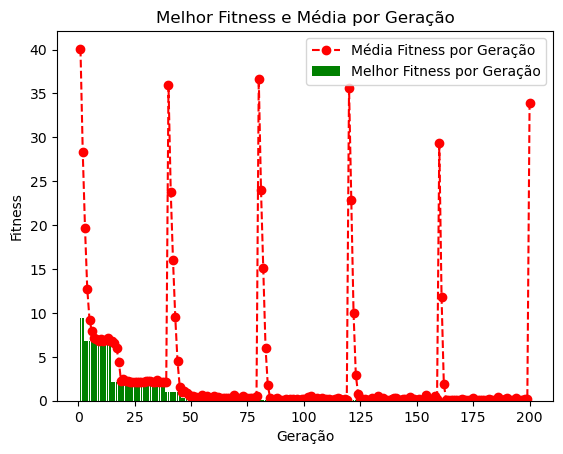

,Generation,Min Fitness,Average Fitness,Max Fitness,Std Fitness
0,0,9.374473,40.091234,77.422331,14.287500
1,1,9.374473,28.372742,54.756497,11.069422
2,2,6.819183,19.719435,48.265312,9.258126
3,3,6.819183,12.763109,29.931688,5.269539
4,4,6.819183,9.245449,15.265654,1.826712
...,...,...,...,...,...
195,195,0.032884,0.032884,0.032884,0.000000
196,196,0.032884,0.032884,0.032884,0.000000
197,197,0.032884,0.140569,10.801367,1.071450
198,198,0.032884,0.176410,14.385504,1.428068


Total execution time: 3.94 seconds


In [270]:

if __name__ == "__main__":
    tempo1 = time.time()

    # Setup
    params = load_params(
        r"/home/pedrov/Documentos/GitHub/Engenharia-Eletrica-UFF/Iniciação Cientifica - Eng Eletrica UFF/evolution_rce_master/src/db/parameters.json"
    )

    gui = GUI_RCE()
    #gui.MaterialAPP()
    setup = Setup(params)
    alg = AlgoritimoEvolutivoRCE(setup)
    data_visual = DataExploration()

    pop_with_repopulation, logbook_with_repopulation, best_variables = alg.run(
        RCE=True,
        fitness_function=rastrigin_decisionVariables,
        decision_variables=(X, y),
    )

    print("\n\nEvolução concluída  - 100%")

    # Visualização dos resultados
    alg.cout("VISUALIZANDO OS RESULTADOS")
    data_visual.show_rastrigin_benchmark(logbook_with_repopulation,best_variables)
    data_visual.visualize(
       logbook_with_repopulation, pop_with_repopulation, repopulation=True
     )
    data_visual.statistics_per_generation_df(logbook_with_repopulation)

    tempo2 = time.time()
    print(f"Total execution time: {round(tempo2-tempo1,2)} seconds")